In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


<Figure size 1080x504 with 0 Axes>

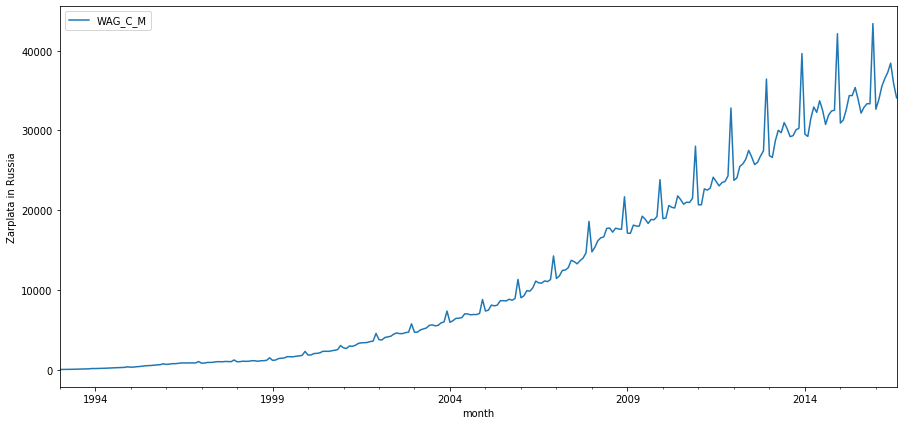

In [11]:
#импортируем данные
zarplata = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
zarplata.plot()
#посмотрим график
plt.ylabel('Zarplata in Russia')
pylab.show()

визуально ряд явно нестационарный с явно меняющейся со временем дисперсией и растущим трендом. .годовая сезонность на лицо

In [12]:
zarplata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB


In [46]:
zarplata

,WAG_C_M,zarplata_box,zarplata_box_diff,zarplata_box_diff2,zarplata_box_diff3,model
month,,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,NaN,46.715881
1993-03-01,23.6,4.931635,NaN,NaN,NaN,23.553700
1993-04-01,30.6,5.549430,NaN,NaN,NaN,28.836552
1993-05-01,37.5,6.063406,NaN,NaN,NaN,39.021991
...,...,...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,-0.366210,-0.470058,37401.947358
2016-05-01,37270.0,56.860441,1.275065,0.332336,0.698546,36745.844017
2016-06-01,38447.0,57.358885,1.316994,0.041929,-0.290406,38429.369574


Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

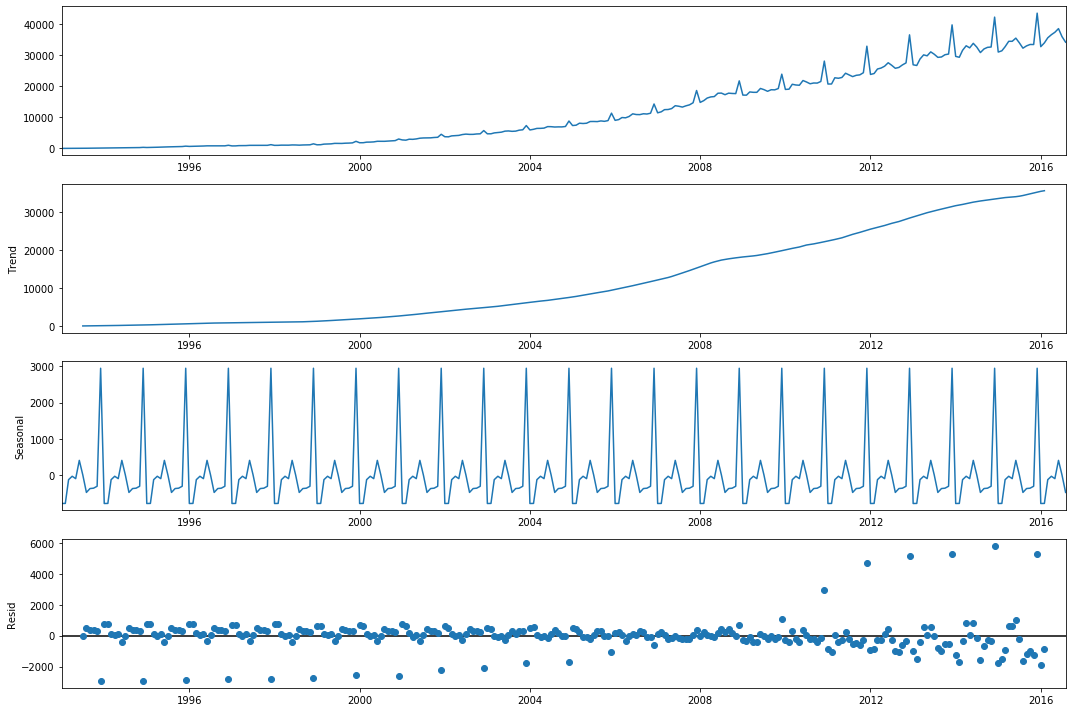

In [13]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zarplata).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zarplata)[1])

собственно что и требовалось доказать, ряд нестационарен. Критерий  дики-фулера не отвергает гипотезу о нестационарности, и визуально виден тренд и разложение на компоненты тому явный показатель.

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


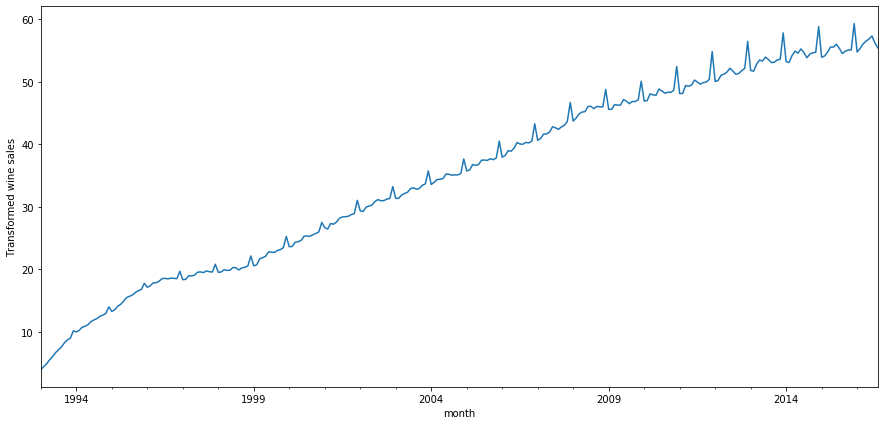

In [27]:
zarplata['zarplata_box'], lmbda = stats.boxcox(zarplata.WAG_C_M)
plt.figure(figsize(15,7))
zarplata.zarplata_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zarplata.zarplata_box)[1])

попробуем избавиться от тренда с помощью сезонного и обычного дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

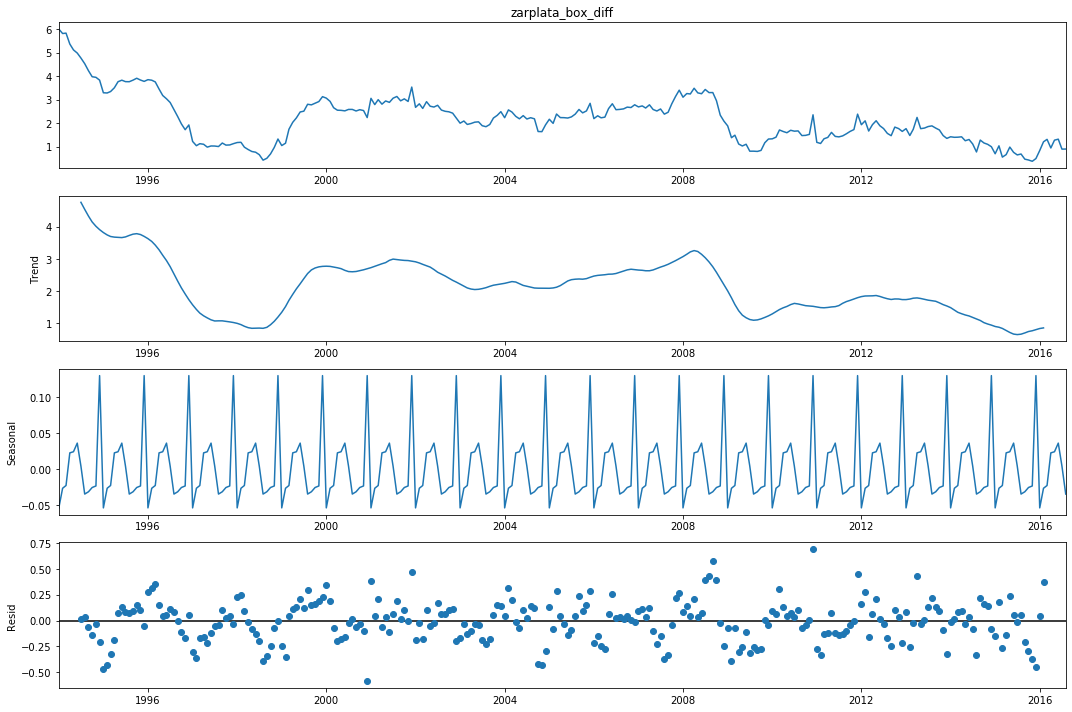

In [30]:
zarplata['zarplata_box_diff'] = zarplata.zarplata_box - zarplata.zarplata_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zarplata.zarplata_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zarplata.zarplata_box_diff[12:])[1])

тренд явно остался, попробуем добавить обычное дифференцирование. хоть дики-фулер и отвергает нестанционарность

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

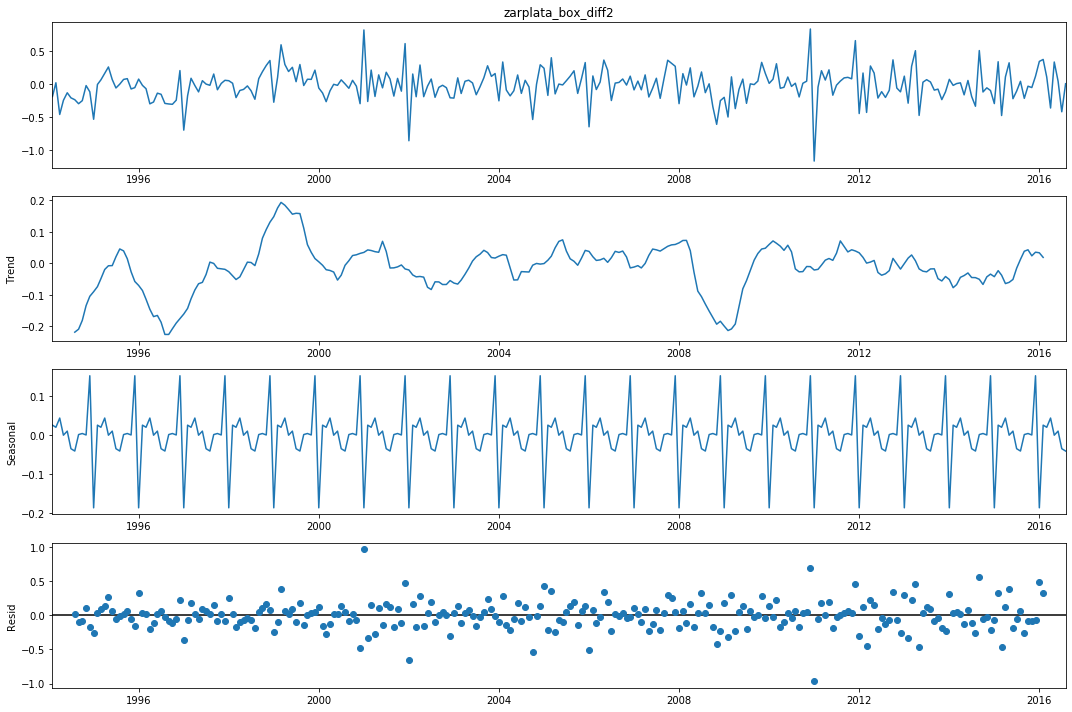

In [31]:
zarplata['zarplata_box_diff2'] = zarplata.zarplata_box_diff - zarplata.zarplata_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zarplata.zarplata_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zarplata.zarplata_box_diff2[13:])[1])

видим, что тренд действительно болтается у нуля, но слева явно остался какой-то кусок зависимости с нашими кризисами 98 + кризис 2009 + легкое блуждание. попробуем еще одно простое дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

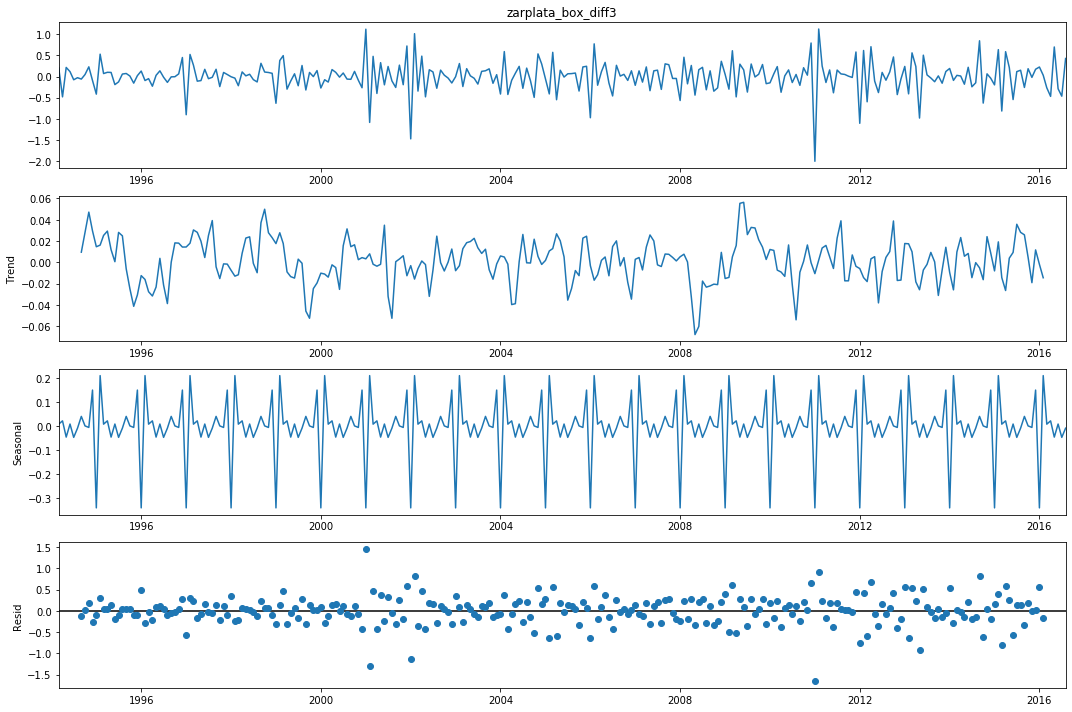

In [32]:
zarplata['zarplata_box_diff3'] = zarplata.zarplata_box_diff2 - zarplata.zarplata_box_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zarplata.zarplata_box_diff3[14:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zarplata.zarplata_box_diff3[14:])[1])

вот это уже больше похоже на стационарный процесс и гипотеза тоже отвергается. Отсюда: D=1 (одно сезонное дифференцирование), d=2 (2 обычных дифференцирования)

Посмотрим на ACF и PACF полученного ряда:

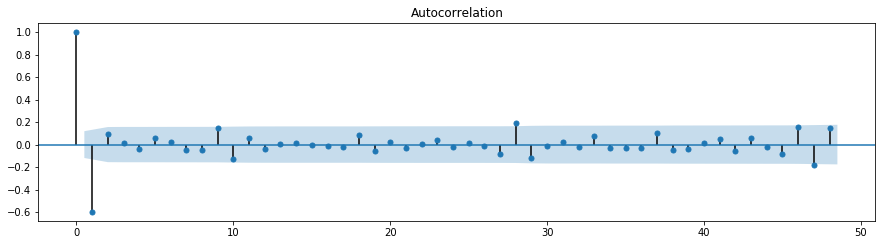

C:\Users\User\Anaconda2\envs\p37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


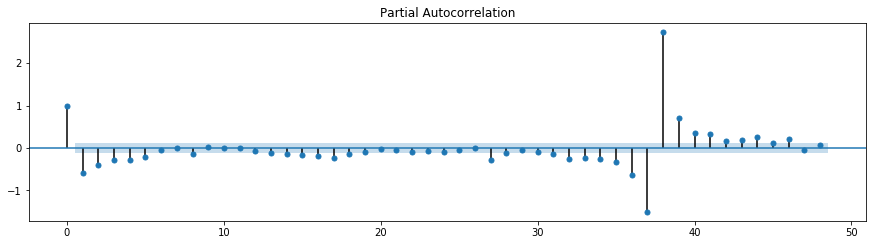

In [33]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(zarplata.zarplata_box_diff3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(zarplata.zarplata_box_diff3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Максимального сезонного лага значительно отличающегося от нуля на графике автокорреляции нет. А значит Q=0
Для q значимо отличается от нуля только первый лаг, т.е. q=1
Максимальный сезонный лаг значительно отличающийся от нуля на графике частичной автокорреляции равен 3. P=3
При маленьких лагах частичной автокорреляции есть 5 лагов отличающихся от нуля, пусть p=5

Начальное приближение: Q=0, q=1, P=3, p=5, D=1, d=2

In [38]:
ps = range(0,6)
d=2
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [39]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [40]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(zarplata.zarplata_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 9s


In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
45  (5, 1, 1, 0)  2.442961
13  (1, 1, 1, 0)  3.172955
46  (5, 1, 2, 0)  3.619187
44  (5, 1, 0, 0)  4.801395
21  (2, 1, 1, 0)  4.832105


Лучшая модель:

In [42]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        zarplata_box   No. Observations:                  284
Model:             SARIMAX(5, 2, 1)x(1, 1, [], 12)   Log Likelihood                   6.779
Date:                             Sun, 21 Jun 2020   AIC                              2.443
Time:                                     17:58:33   BIC                             31.230
Sample:                                 01-01-1993   HQIC                            14.003
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1718      0.052     -3.307      0.001      -0.274      -0.070
ar.L2          0.0445      

судя по статистике остатки неавтокррелированы (Prob(Q):0.28) 

Визуальный анализ

Критерий Стьюдента: p=0.075632
Критерий Дики-Фуллера: p=0.000000


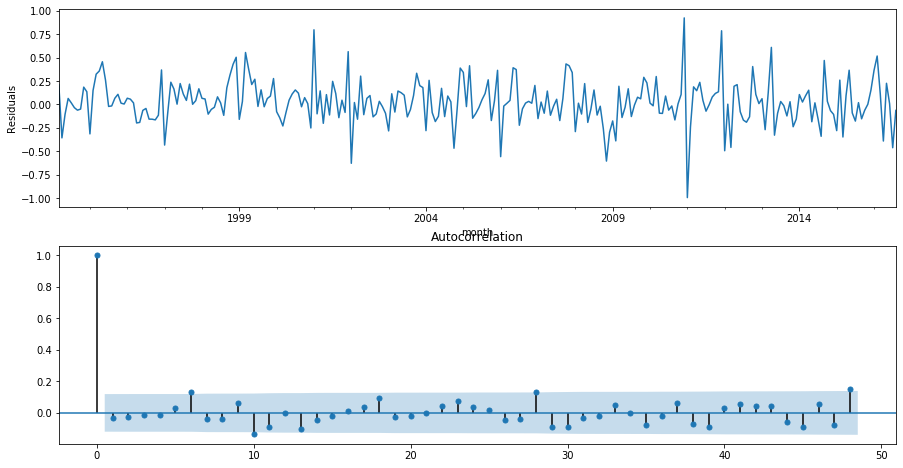

In [43]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

тренда нет, сезонности нет, похоже на шум

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса (согласно summary Ljung-Box (Q): 44.59 больше 0.05,  а значит неавтокоррелированы) и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

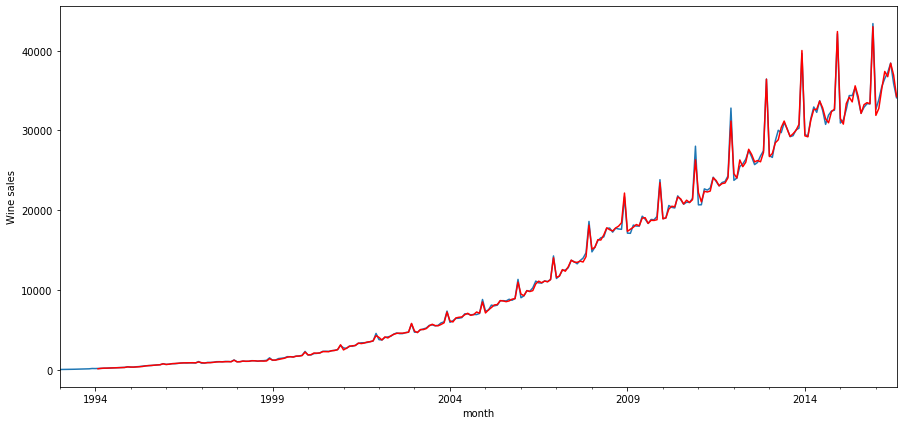

In [44]:
zarplata['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
zarplata.WAG_C_M.plot()
zarplata.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

офигенно описывает

делаем прогноз

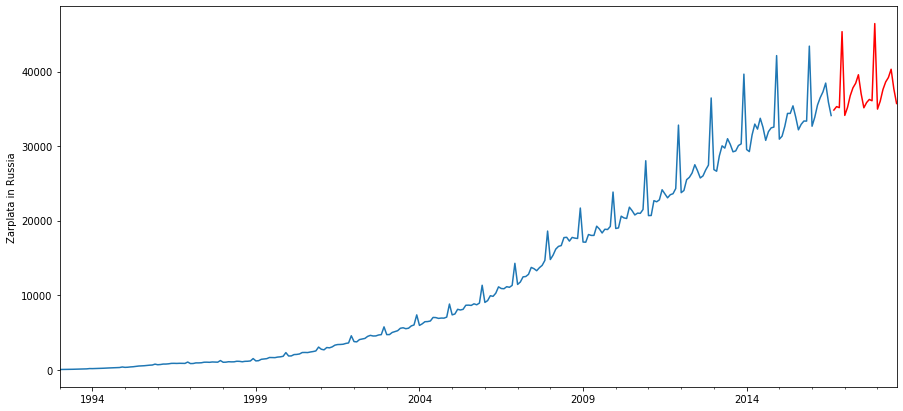

In [49]:
zarplata2 = zarplata[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= zarplata2.columns)
zarplata2 = pd.concat([zarplata2, future])
zarplata2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
zarplata2.WAG_C_M.plot()
zarplata2.forecast.plot(color='r')
plt.ylabel('Zarplata in Russia')
pylab.show()

получилось!